In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn

import utils
import aug_functions
import bnn_aug

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [3]:
data = pd.read_csv('../data/plasticc/good_objects.csv', index_col=0)

data = data[data.detected == 1]
data.head()

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
222,13,60532.3019,2,24.529644,1.046373,1,3.790512,0
223,13,60532.3097,1,23.404964,0.992504,1,3.675929,0
224,13,60532.3173,3,36.069386,1.568371,1,3.875155,0
225,13,60532.3282,4,42.765503,2.305008,1,3.938479,0
226,13,60532.3392,5,36.567162,5.439748,1,3.987288,0


In [4]:
object_ids = np.unique(data.object_id)

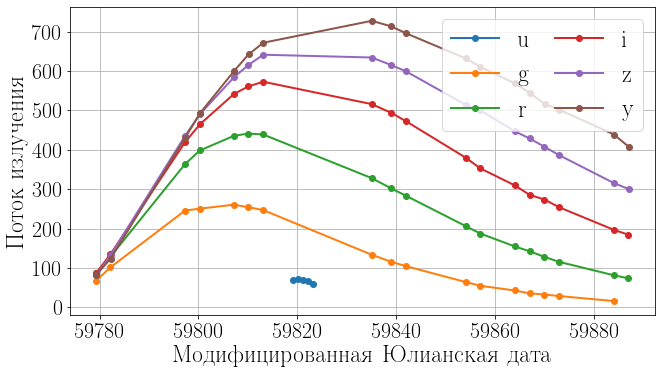

In [5]:
anobject = aug_functions.get_object(data, 34299)

aug_functions.plot_light_curves(anobject)

In [6]:
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

y_train = anobject_train['flux'].values
y_test  = anobject_test['flux'].values

from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
X_train_ss = ss_x.fit_transform(X_train)
X_test_ss = ss_x.transform(X_test)

ss_y = StandardScaler()
y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))
y_test_ss = ss_y.transform(y_test.reshape((-1, 1)))

reg = bnn_aug.FitBNNRegressor(n_hidden=50, n_epochs=200, lr=0.1, kl_weight=0.2, optimizer='Adam')
reg.fit(X_train_ss, y_train_ss)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
res = ss_y.inverse_transform(reg.predict(X_test_ss))
anobject_test_pred['flux'] = np.maximum(res, np.zeros(res.shape))

# predict flux for known observations
anobject_train_pred = anobject_train.copy()
res = ss_y.inverse_transform(reg.predict(X_train_ss))
anobject_train_pred['flux'] = np.maximum(res, np.zeros(res.shape))

# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'])
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  76.52151439810908
MAE:  60.86876660233632
RSE:  0.3637673863231535
RAE:  0.32501074875716085
MAPE:  36.90927344786263


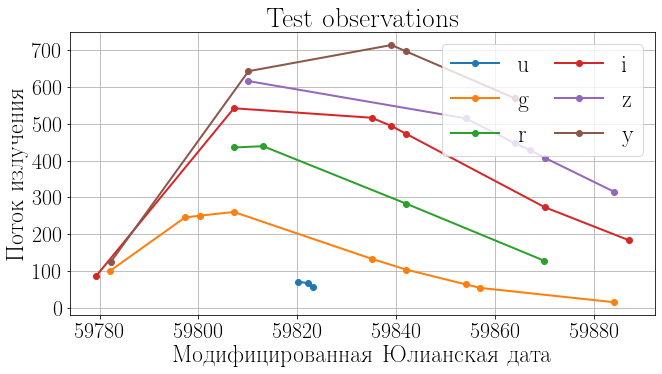

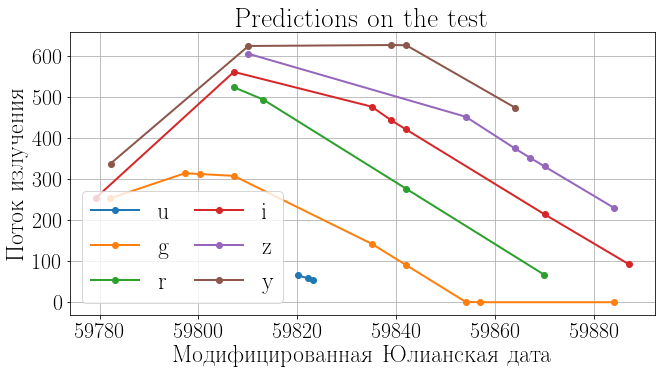

In [7]:
aug_functions.plot_light_curves(anobject_test, "Test observations")
aug_functions.plot_light_curves(anobject_test_pred, "Predictions on the test")

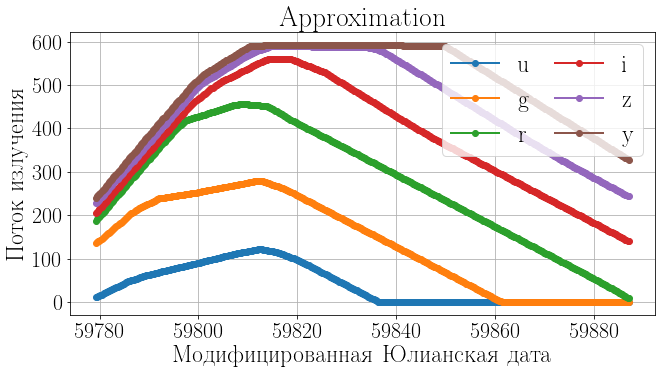

In [8]:
approx_object = aug_functions.create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values

X_ss = ss_x.transform(X)
res = ss_y.inverse_transform(reg.predict(X_ss))
approx_object['flux'] = np.maximum(res, np.zeros(res.shape))
aug_functions.plot_light_curves(approx_object, "Approximation")

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

In [10]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

def test_model(n_hidden=50, n_epochs=200, lr=0.1, kl_weight=0.2, optimizer='Adam'):
    metrics = []
    index = np.random.choice(len(object_ids), size=len(object_ids) // 5)
    for i in index:
        good_id = object_ids[i]

        # get an object
        anobject = aug_functions.get_object(data, good_id)

        # train / test split
        anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

        y_train = anobject_train['flux'].values
        y_test  = anobject_test['flux'].values

        ss_t = StandardScaler().fit(anobject_train['mjd'].values.reshape((-1, 1)))
        t        = ss_t.transform(anobject_train['mjd'].values.reshape((-1, 1)))
        X_noise = np.random.normal(0, 1, t.shape)
        X_train = np.concatenate((t, X_noise, anobject_train['log_lam'].values.reshape((-1, 1))), axis=1) 
        
        t        = ss_t.transform(anobject_test['mjd'].values.reshape((-1, 1)))
        X_noise = np.random.normal(0, 1, t.shape)
        X_test = np.concatenate((t, X_noise, anobject_test['log_lam'].values.reshape((-1, 1))), axis=1)
        
        ss_x = StandardScaler().fit(X_train)
        X_train_ss = ss_x.transform(X_train)
        X_test_ss = ss_x.transform(X_test)

        ss_y = StandardScaler().fit(y_train.reshape((-1, 1)))
        y_train_ss = ss_y.transform(y_train.reshape((-1, 1)))

        # fit a regression model to approximate light curves
        reg = bnn_aug.FitBNNRegressor(n_hidden=n_hidden, 
                                     n_epochs=n_epochs, 
                                     kl_weight=kl_weight,          
                                     lr=lr, 
                                     optimizer=optimizer)
        reg.fit(X_train_ss, y_train_ss)

        # predict flux for unseen observations
        anobject_test_pred = anobject_test.copy()
        y_pred = ss_y.inverse_transform(reg.predict(X_test_ss))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        metrics.append(mape)

    return np.mean(metrics)

  0%|          | 0/20 [00:00<?, ?it/s]

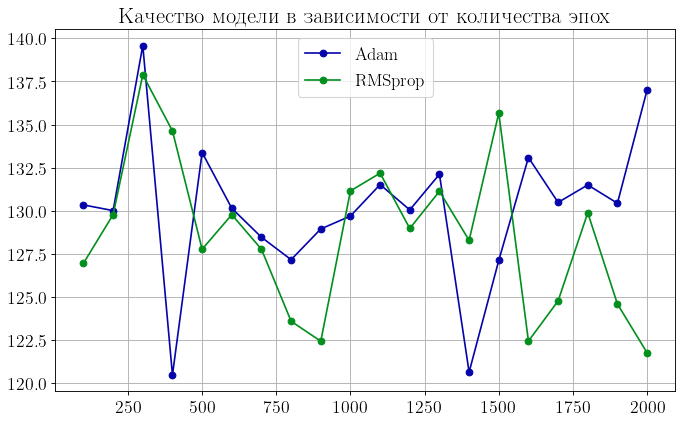

In [11]:
sgd_metrics = []
adam_metrics = []
RMSprop_metrics = []

epochs_range = np.arange(100, 2001, 100)
for epochs in tqdm_notebook(epochs_range):
    adam_mape = test_model(n_hidden=50, n_epochs=epochs, lr=0.1, kl_weight=0.1, optimizer='Adam')
    adam_metrics.append(adam_mape)
    RMSprop_mape = test_model(n_hidden=50, n_epochs=epochs, lr=0.01, kl_weight=0.1, optimizer='RMSprop')
    RMSprop_metrics.append(RMSprop_mape)
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества эпох", fontsize=20)
plt.grid(True)
plt.plot(epochs_range, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(epochs_range, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nepochs_bayesian.pdf")

  0%|          | 0/21 [00:00<?, ?it/s]

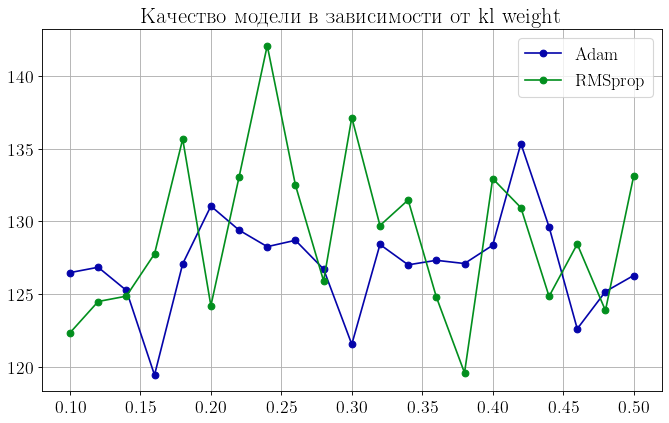

In [13]:
adam_metrics = []
RMSprop_metrics = []

kl_weight = np.arange(0.1, 0.51, 0.02)
for kl in tqdm_notebook(kl_weight):
    adam_mape = test_model(n_hidden=50, n_epochs=200, lr=0.1, kl_weight=kl, optimizer='Adam')
    adam_metrics.append(adam_mape)
    RMSprop_mape = test_model(n_hidden=50, n_epochs=200, lr=0.01, kl_weight=kl, optimizer='RMSprop')
    RMSprop_metrics.append(RMSprop_mape)
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от kl weight", fontsize=20)
plt.grid(True)
plt.plot(kl_weight, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(kl_weight, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_kl_bayesian.pdf")

  0%|          | 0/27 [00:00<?, ?it/s]

ValueError: x and y must have same first dimension, but have shapes (21,) and (27,)

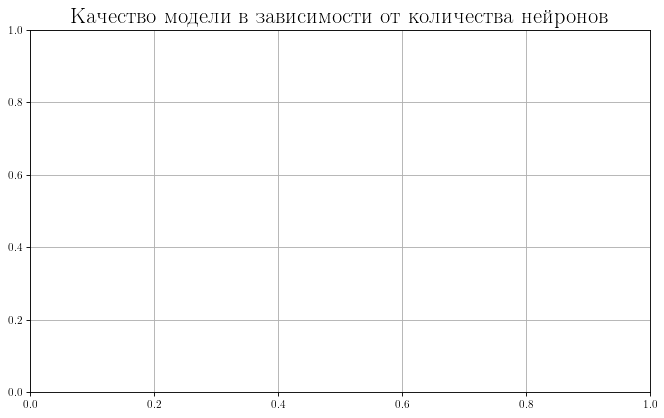

In [14]:
adam_metrics = []
RMSprop_metrics = []

neurons_number = np.arange(10, 401, 15)
for neurons in tqdm_notebook(neurons_number):
    adam_mape = test_model(n_hidden=neurons, n_epochs=200, lr=0.1, kl_weight=0.15, optimizer='Adam')
    adam_metrics.append(adam_mape)
    RMSprop_mape = test_model(n_hidden=neurons, n_epochs=200, lr=0.01, kl_weight=0.15, optimizer='RMSprop')
    RMSprop_metrics.append(RMSprop_mape)
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества нейронов", fontsize=20)
plt.grid(True)
plt.plot(neurons_number, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(neurons_number, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nhidden_bayesian.pdf")

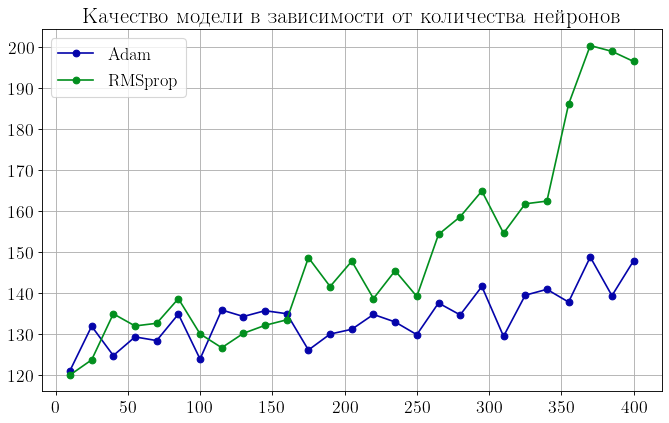

In [15]:
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества нейронов", fontsize=20)
plt.grid(True)
plt.plot(neurons_number, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(neurons_number, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nhidden_bayesian.pdf")

### Посмотрим разброс предсказанных значений

In [15]:
def plot_light_curves_with_sigma(anobject, anobject_real, title=""):
    anobject = anobject.sort_values('mjd')
    colors = ['C'+str(i) for i in range(6)]
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        light_curve_real = get_passband(anobject_real, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=2., color=colors[passband])
        plt.fill_between(light_curve['mjd'].values, 
                         light_curve['flux'].values+3*light_curve['flux_err'].values, 
                         light_curve['flux'].values-3*light_curve['flux_err'].values, label=passband2name[passband], alpha=0.5, color=colors[passband])
        plt.scatter(light_curve_real['mjd'].values, light_curve_real['flux'].values, linewidth=1, color=colors[passband])
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

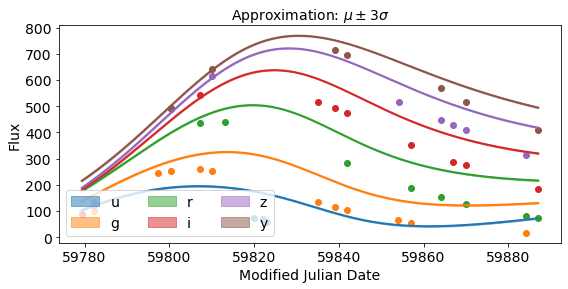

In [71]:
approx_object = create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values
X_ss = ss.transform(X)

approx_flux, approx_flux_err = reg.predict_n_times(X_ss, n_times=1000)
approx_object['flux'], approx_object['flux_err'] = ss_y.inverse_transform(approx_flux), approx_flux_err

plot_light_curves_with_sigma(approx_object, anobject_test, "Approximation: " + r"$\mu \pm 3\sigma$")
plt.savefig('approx_light_curve_34299.pdf', format='pdf')

# Test on many objects

In [26]:
from joblib import Parallel, delayed

In [27]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

def one_object_run(i):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    if not is_good(anobject): 
        return None
    
    # print("Object ", i, " with ", len(anobject), " observations")
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.2, random_state=11)
    
    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test  = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    # fit a regression model to approximate light curves
    if MODEL == "BNN":   
        reg = FitBNNRegressor(n_hidden=200, n_epochs=1000, lr=0.1, kl_weight=0.5, optimizer='Adam', debug=0)
    elif MODEL == "GP":
        kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
        reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, optimizer="fmin_l_bfgs_b", random_state=42)

    reg.fit(X_train_ss, y_train)

    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'] = reg.predict(X_test_ss)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    
    return metrics

In [28]:
def gen_report(metrics):
    report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = [i] + list(met)
    return report

In [29]:
%%time

MODEL = "GP"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_gp = gen_report(metrics)

CPU times: user 41.7 s, sys: 2.15 s, total: 43.8 s
Wall time: 44.4 s


In [30]:
%%time

MODEL = "BNN"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_bnn = gen_report(metrics)

CPU times: user 27.8 s, sys: 1.11 s, total: 28.9 s
Wall time: 1min 11s


In [31]:
print("Metrics for GP:")
np.round(report_gp.mean(), 2)

Metrics for GP:


ID      1084.47
RMSE      24.65
MAE       12.28
RSE        0.16
RAE        0.14
MAPE      16.55
dtype: float64

In [32]:
print("Metrics for BNN:")
np.round(report_bnn.mean(), 2)

Metrics for BNN:


ID      1084.47
RMSE      26.21
MAE       15.87
RSE        0.18
RAE        0.15
MAPE      15.84
dtype: float64

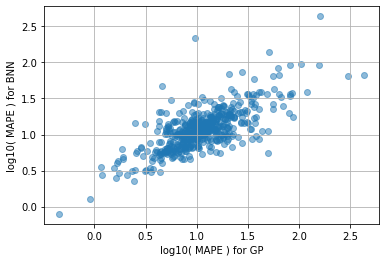

In [33]:
plt.scatter(np.log10(report_gp['MAPE'].values.astype(np.float)), 
            np.log10(report_bnn['MAPE'].values.astype(np.float)), alpha=0.5)
plt.xlabel("log10( MAPE ) for GP")
plt.ylabel("log10( MAPE ) for BNN")
plt.grid(b=1)
plt.show()

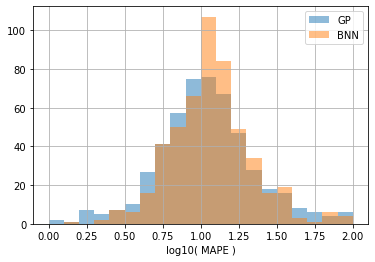

In [34]:
bins = np.linspace(0, 2, 21)
plt.hist(np.log10(report_gp['MAPE'].values.astype(np.float)), bins=bins, alpha=0.5, label='GP')
plt.hist(np.log10(report_bnn['MAPE'].values.astype(np.float)), bins=bins, alpha=0.5, label='BNN')
plt.xlabel("log10( MAPE )")
plt.grid(b=1)
plt.legend()
plt.show()